# Dataset

Para a nossa análise utilizaremos o conjunto de dados do Titanic, mundialmente conhecido e muito utilizado para projetos de machine learning, como um "Hello world" do mundo da ciêncida de dados.

Link para [download](https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59e4fe3d_titanic-data-6/titanic-data-6.csv)

# Perguntas

* Qual era o perfil geral dos passageiros?
* Como variou o preço da passagem em relação ao local de embarque?
* Quais fatores mais influenciaram a taxa de sobrevivência dos passageiros?
* O número de familiares a bordo do titanic influenciou na taxa de sobrevivência?
* O número de pais/filhos a bordo do titanic influenciou na taxa de sobrevivência? 

In [199]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [200]:
df = pd.read_csv('titanic-data-6.csv', index_col='PassengerId')

In [201]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Limpeza de dados

Vamos padronizar os nomes das colunas para minúsculo

In [202]:
df.rename(columns=lambda x: x.lower(), inplace=True)

Podemos perceber que a idade está sendo tratada como float, vamos ver porque:

In [203]:
', '.join([str(s) for s in df.age.unique()])

'22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0, 14.0, 4.0, 58.0, 20.0, 39.0, 55.0, 31.0, 34.0, 15.0, 28.0, 8.0, 19.0, 40.0, 66.0, 42.0, 21.0, 18.0, 3.0, 7.0, 49.0, 29.0, 65.0, 28.5, 5.0, 11.0, 45.0, 17.0, 32.0, 16.0, 25.0, 0.83, 30.0, 33.0, 23.0, 24.0, 46.0, 59.0, 71.0, 37.0, 47.0, 14.5, 70.5, 32.5, 12.0, 9.0, 36.5, 51.0, 55.5, 40.5, 44.0, 1.0, 61.0, 56.0, 50.0, 36.0, 45.5, 20.5, 62.0, 41.0, 52.0, 63.0, 23.5, 0.92, 43.0, 60.0, 10.0, 64.0, 13.0, 48.0, 0.75, 53.0, 57.0, 80.0, 70.0, 24.5, 6.0, 0.67, 30.5, 0.42, 34.5, 74.0'

Alguns registros possuem valores abaixo de 1, ou seja, provavelmente são bebês com menos de 1 um ano.

In [204]:
print(f'Número de passageiros com menos de 1 ano: {sum(df.age <1)}')

Número de passageiros com menos de 1 ano: 7


Podemos perceber também que existe uma certa quantidade de idades faltantes:

In [205]:
sum(df.age.isnull())

177

Existem algumas colunas que serão desnecessárias para a nossa análise, como a "ticket" e a "cabin", vamos retirá-las.

In [206]:
clean_df = df.drop(columns=['ticket', 'cabin'])

A coluna "embarked" não deixa muito explícito qual o nome do local de embarque, nesse caso vamos utilizar como referência o dicionário de dados disponibilizado no site [kaggle](https://www.kaggle.com/c/titanic/data), para enriquecer nossos dados.

In [207]:
clean_df.loc[clean_df.embarked == 'S', 'embarked'] = 'Southampton'
clean_df.loc[clean_df.embarked == 'C', 'embarked'] = 'Cherbourg'
clean_df.loc[clean_df.embarked == 'Q', 'embarked'] = 'Queenstown'

In [208]:
clean_df.loc[clean_df.sex == 'male', 'sex'] = 'masculino'
clean_df.loc[clean_df.sex == 'female', 'sex'] = 'feminino'

In [209]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
fare        891 non-null float64
embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.6+ KB


Apesar de existirem muitos valores faltantes na coluna "age", se estratificarmos pela classe à qual o passageiro pertence, podemos perceber que existe um desbalanceamento, os valores faltantes para a terceira classe representa 27% do total, enquanto que para a segunda classe representa apenas 5% do total, como podemos observar na tabela abaixo:

In [210]:
comparacao = pd.concat([
    pd.Series(
        clean_df.loc[clean_df.age.isnull(), 'pclass'].value_counts(),
        name='sem_idade'),
    pd.Series(
        clean_df.loc[-clean_df.age.isnull(), 'pclass'].value_counts(),
        name='com_idade')
],
                       axis=1).sort_index()
comparacao.loc[:, 'perc_%'] = (comparacao['sem_idade'] / (
    comparacao['sem_idade'] + comparacao['com_idade'])) * 100
comparacao

,sem_idade,com_idade,perc_%
1,30,186,13.888889
2,11,173,5.978261
3,136,355,27.698574


Desse modo, iremos substituir os valores faltantes pela média de cada classe.

In [211]:
for i in range(1, 4):
    age_mean = clean_df.query(f'pclass == {i}').age.mean()
    clean_df.loc[clean_df.pclass == i, 'age'] = \
        clean_df.loc[clean_df.pclass == i, 'age'].fillna(age_mean)

## Exploração dos dados

### Como era o perfil geral dos passageiros do Titanic?

Para responder a essa pergunta, vamos dar uma olhada na idade, sexo, classe social, tarifa de embarque e local de embarque.

Como somente a partir do dados do nosso conjunto não é possivel determinar com exatidão qual a classe social dos passageiros, que por si só já não é um conceito exato, vamos usar como parâmetro o em qual classe do navio ele estava navegando.

In [212]:
def ax_style(ax, grid_axis='both'):
    '''
    Ajuda a estilizar os gráficos de uma forma padrão
    
    Args:
    ax: eixo do gráfico
    grid_axis: eixo para desenhar a grade
    '''
    if grid_axis not in ['x', 'y', 'both']:
        grid_axis = 'both'
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, linestyle='--', which='major', axis=grid_axis,
                 color='grey', alpha=.25)
    return ax

#### Idade

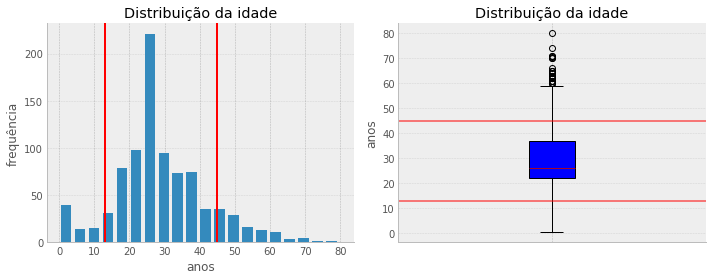

In [213]:
lim_inf = 13
lim_sup = 45

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(clean_df.age, bins=20, width=3)
ax1.set(title="Distribuição da idade", xlabel="anos", ylabel="frequência")
ax1.axvline(x=lim_inf, c='red')
ax1.axvline(x=lim_sup, c='red')

ax2.boxplot(clean_df.age, vert=True, patch_artist=True, meanline=True)
ax2.set(
    title="Distribuição da idade", xlabel="", ylabel="anos", xticklabels='')
ax2.axhline(y=lim_inf, c='red', alpha=0.5)
ax2.axhline(y=lim_sup, c='red', alpha=0.5)
for ax in [ax1, ax2]:
    ax = ax_style(ax, 'y')
fig.set_figwidth(10)
fig.tight_layout()

A partir do gráfico conseguimos percerber que a grande maioria dos passageiros tem entre 13 e 45 anos.

In [214]:
x = (clean_df.query(f"age >={lim_inf} and age <= {lim_sup}").shape[0] /
     clean_df.shape[0]) * 100
print(f'{x:.1f}% dos passageiros possuía entre {lim_inf} e {lim_sup} anos')

80.7% dos passageiros possuía entre 13 e 45 anos


#### Sexo

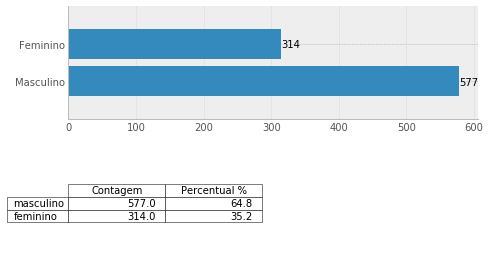

In [215]:
counts = clean_df.sex.value_counts()
counts.name = 'Contagem'
perc = round((counts / clean_df.sex.shape[0]) * 100, 1)
perc.name = 'Percentual %'
tabela = pd.concat([counts, perc], axis=1)



fig = plt.figure()
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0))
widths = clean_df.sex.value_counts()
labels = pd.Series(clean_df.sex.value_counts().index.get_values())
labels = labels.apply(lambda x: x[0].upper() + x[1:])
y = [1, 2]

ax.barh(width=widths, y=y, height=0.8)
ax.set_yticks([1, 2])
ax.set_yticklabels(labels)
ax.set_ylim((0, 3))
for i, width in enumerate(widths):
    ax.annotate(width, xy=(width + 1, i + 0.9), ha='left')

ax2.set_axis_off()
ax2.table(
    rowLabels=tabela.index.get_values(),
    colLabels=['Contagem', 'Percentual %'],
    cellText=tabela.get_values(),
    loc='center')
ax = ax_style(ax, 'x')
fig.tight_layout()
fig.set_figwidth(7)

Podemos percerber que a grande maioria dos passageiros era do sexo masculino.

#### Familiares

Vamos considerar como familiares o somatório das colunas SibSp e ParCh

In [216]:
clean_df['familiares'] = clean_df[['sibsp', 'parch']].apply(sum, axis=1)

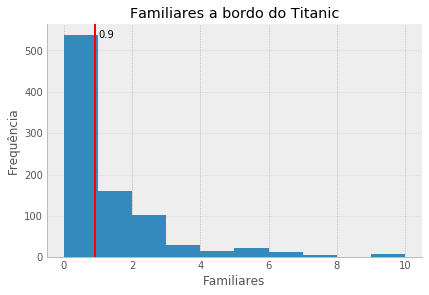

In [217]:
fam_mean = clean_df.familiares.mean()

fig, ax = plt.subplots()

ax.hist(clean_df.familiares, 10)
ax.axvline(x=fam_mean, c='red')
ax.set(
    title='Familiares a bordo do Titanic',
    xlabel='Familiares',
    ylabel='Frequência')
ax = ax_style(ax, 'y')
ax.annotate(f'{fam_mean:.1f}', xy=(fam_mean + 0.1, 530));

Através do histograma conseguimos ver que a grande maioria dos passageiros não viajava com familiares.

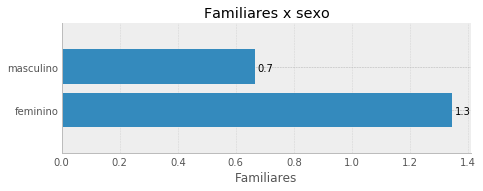

In [218]:
data = clean_df.loc[:, np.s_['familiares', 'sex']].groupby('sex').mean()
fig = plt.figure()
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
widths = data.get_values().ravel()
labels = pd.Series(['feminino', 'masculino'])
y = [1, 2]

ax.barh(width=widths, y=y, height=0.8)
ax.set_yticks([1, 2])
ax.set_yticklabels(labels)
ax.set_ylim((0, 3))
ax.set(title='Familiares x sexo', xlabel='Familiares')
for i, width in enumerate(widths):
    ax.annotate(f'{width:.1f}', xy=(width + 0.01, i + 0.9), ha='left')
ax_style(ax, 'x')
fig.tight_layout()
fig.set_figwidth(7)
fig.set_figheight(5)

Outro dado interessante é que as mulheres estavam acompanhadas em média de mais familiares que os homens, o que condiz com os costumes da época.

#### Classe

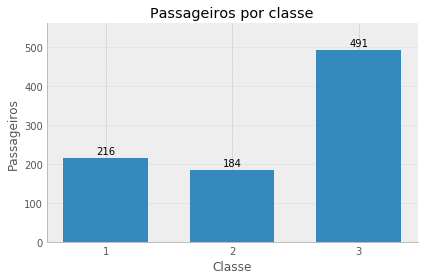

In [219]:
heights = clean_df['pclass'].value_counts().sort_index().get_values()
labels = np.arange(1, 4)
bar_width = 1 / 1.5
fig, ax = plt.subplots()
ax.bar(x=labels, height=heights, width=bar_width)
ax.set_xticks(labels)
ax.set(title='Passageiros por classe', xlabel='Classe', ylabel='Passageiros')
ax.set_ylim(0, 560)
for i, v in enumerate(heights):
    ax.annotate(v, xy=(i + 1, v + 10), ha='center')
ax_style(ax, 'y')
fig.tight_layout()

In [220]:
data = pd.crosstab(clean_df.loc[:, 'pclass'], clean_df.loc[:, 'sex'])

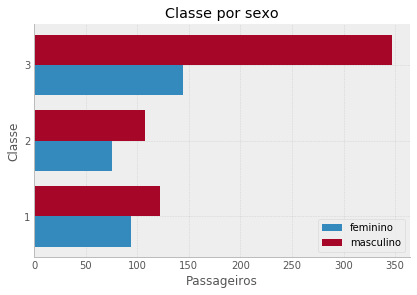

In [221]:
data = pd.crosstab(clean_df.loc[:, 'pclass'], clean_df.loc[:, 'sex'])
fig, ax = plt.subplots()
bar_width = .4
index = data.index.get_values()
sexes = data.columns.get_values().tolist()
for i, sex in enumerate(sexes):
    ax.barh(
        y=index + (bar_width * i),
        width=data.loc[:, sex],
        label=sex,
        height=bar_width)

ax.set_title('Classe por sexo')
ax.set_xlabel('Passageiros')
ax.set_ylabel('Classe')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(index)
ax_style(ax)
ax.legend();

O gráfico acima mostra como os passageiros de diferentes sexos estão distribuídos pelas classes dos navios, é notável que os passageiros da terceira classe são, em sua maioria, do sexo masculino.

#### Porto de embarque

Vamos checar quantos passageiros embarcaram em cada porto.

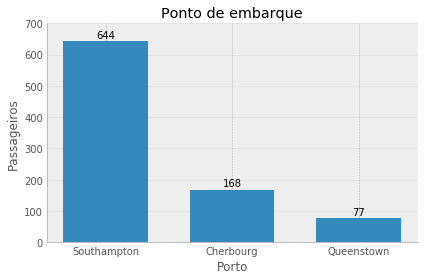

In [222]:
data = clean_df.embarked.value_counts()
labels = data.index.get_values()
bar_width = 1 / 1.5
fig, ax = plt.subplots()

ax.bar(
    x=np.arange(1, 4),
    height=data,
    width=bar_width,
    tick_label=labels.tolist())
ax.set(title='Ponto de embarque', ylabel='Passageiros', xlabel='Porto')
for i, v in enumerate(data):
    ax.annotate(v, xy=(i + 1, v + 10), ha='center')
fig.tight_layout()
ax_style(ax, 'y')
ax.set_ylim(0, 700);

### Perfil
O perfil mais comum de um passageiro do Titanic era:

* Homem
* Entre 13 e 45 anos
* Com mais 1 familiar a bordo 
* Viajando na terceira classe
* Embarcou em Southampton
* e pagou 27,1 libras pela passagem

### Como variou o preço da passagem entre os pontos de embarque?

Comparando a tarifa média entre cada porto.

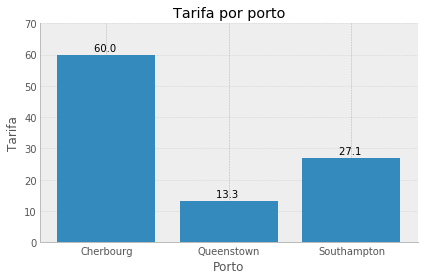

In [223]:
data = clean_df.loc[:, np.s_['fare', 'embarked']].\
        groupby('embarked').mean()
labels = data.index.get_values()
data = [i[0] for i in data.get_values().tolist()]
fig, ax = plt.subplots()

ax.bar(x=np.arange(1, 4), height=data, tick_label=labels.tolist())
ax.set(title='Tarifa por porto', ylabel='Tarifa', xlabel='Porto')
ax.set_ylim(0, 70)
for i, v in enumerate(data):
    ax.annotate(f'{ v:.1f} ', xy=(i + 1, v + 1), ha='center')

ax_style(ax, 'y')
fig.tight_layout()

In [224]:
f'A passagem média de Cherbourg era {(data[0]/data[1])*100:.2f}% mais cara que a do Porto de Queenstown e {(data[0]/data[2])*100:.2f}% mais cara que a do Porto de Southampton'

'A passagem média de Cherbourg era 451.60% mais cara que a do Porto de Queenstown e 221.40% mais cara que a do Porto de Southampton'

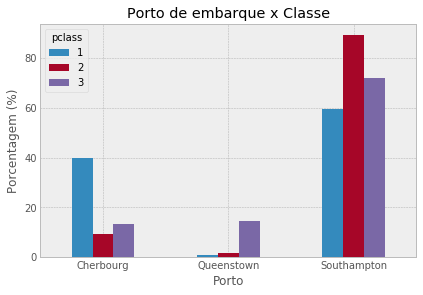

In [225]:
(pd.crosstab(clean_df.embarked, clean_df.pclass, normalize='columns')*100).plot(kind='bar')
plt.title('Porto de embarque x Classe')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Porto')
plt.xticks(rotation=0);

A partir do gráfico acima, podemos concluir que o porto de Cherbourg recebeu 40% dos passageiros da primeira classe e que Southampton quase todos os passageiros da segunda e terceira classe, o que pode ter "puxado" a média da taxa de embarque para baixo.

### Quais fatores influenciaram na taxa de sobrevivência dos passageiros? 

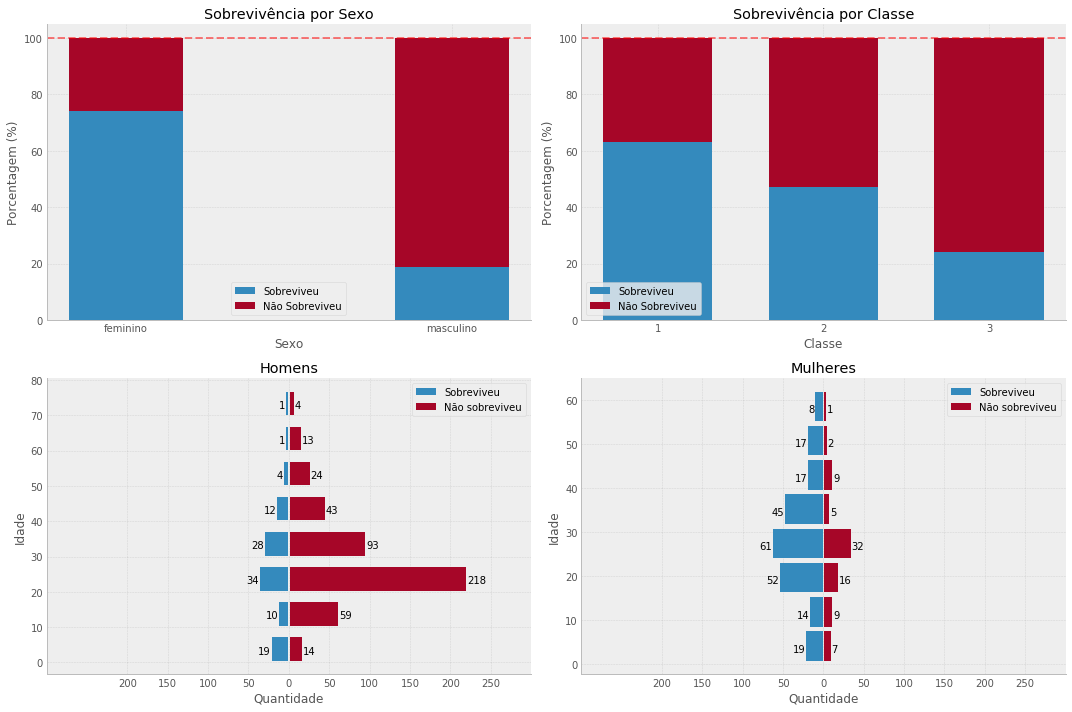

In [226]:
fig, ((ax, ax3), (ax1, ax2)) = plt.subplots(2, 2)
data = pd.crosstab(clean_df.survived, clean_df.sex, normalize='columns') * 100
surv = data.loc[1]
not_surv = data.loc[0]
index = np.arange(2)
bar_width = 0.35

ax.bar(x=index, width=bar_width, height=surv, label='Sobreviveu')
ax.bar(
    x=index,
    width=bar_width,
    bottom=surv,
    height=not_surv,
    label='Não Sobreviveu')
ax.axhline(y=100, color='red', alpha=0.5, linestyle='--')
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.set_title('Sobrevivência por Sexo')
ax.set_xlabel('Sexo')
ax.set_ylabel('Porcentagem (%)')
ax.set_xticks(index)
ax.set_xticklabels(data.columns.get_values())
ax.legend()
ax_style(ax)

for sex, ax in zip(['masculino', 'feminino'], (ax1, ax2)):
    data = {
        'surv': clean_df.query(f'survived == 1 and sex == "{sex}"').age,
        'not_surv': clean_df.query(f'survived == 0 and sex =="{sex}"').age
    }
    n, bins, _ = ax.hist(data['surv'], bins=8)
    n2, bins2, _ = ax.hist(data['not_surv'], bins=bins)
    ax.clear()
    ax.barh(
        y=bins[:-1],
        width=n * (-1) -1,
        height=(10 / 15) * 10,
        label='Sobreviveu',
        left=-1,
        align='edge')
    for x, y in zip(n, bins):
        ax.annotate(int(x), xy=((x * -1) - 3, y + 2), ha='right')
    ax.barh(
        y=bins[:-1],
        width=n2+1,
        height=(10 / 15) * 10,
        label='Não sobreviveu',
        left=1,
        align='edge')
    for x, y in zip(n2, bins):
        ax.annotate(int(x), xy=((x) + 3, y + 2), ha='left')
    ax.set_xlim(-300, 300)
    ax.legend()
    ax.grid(alpha=0.25)
    if sex == 'masculino':
        ax.set_title('Homens')
    else:
        ax.set_title('Mulheres')
    ax.set_xlabel('Quantidade')
    ax.set_ylabel('Idade')
    ax.set_xticks([-200, -150, -100, -50, 0, 50, 100, 150, 200, 250])
    ax.set_xticklabels([200, 150, 100, 50, 0, 50, 100, 150, 200, 250])
    ax.legend()
    ax_style(ax)
    
data = pd.crosstab(
    clean_df.survived, clean_df.pclass, normalize='columns') * 100
surv = data.loc[1]
not_surv = data.loc[0]
index = np.arange(3)
bar_width = 0.66

ax3.bar(x=index, width=bar_width, height=surv, label='Sobreviveu')
ax3.bar(
    x=index,
    width=bar_width,
    bottom=surv,
    height=not_surv,
    label='Não Sobreviveu')
ax3.axhline(y=100, color='red', alpha=0.5, linestyle='--')
ax3.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax3.set_title('Sobrevivência por Classe')
ax3.set_xlabel('Classe')
ax3.set_ylabel('Porcentagem (%)')
ax3.set_xticks(index)
ax3.set_xticklabels(data.columns.get_values())
ax3.legend()
ax_style(ax3)

fig.set_figheight(10)
fig.set_figwidth(15)
fig.tight_layout()

Podemos perceber o sexo é um dos fatores que mais influenciaram a a chance de sobrevivência de um passageiro.

### O número de pais/filhos a bordo do titanic influenciou na taxa de sobrevivência? 

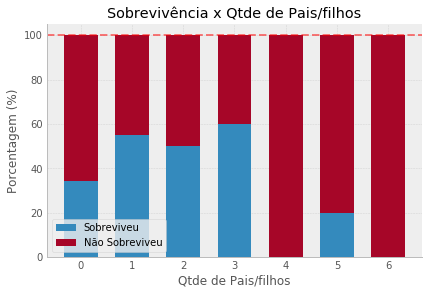

In [227]:
fig, ax3 = plt.subplots()
data = pd.crosstab(
     clean_df.parch, clean_df.survived, normalize='index') * 100
surv = data.iloc[:,1]
not_surv = data.iloc[:,0]
index = np.arange(7)
bar_width = 0.66

ax3.bar(x=index, width=bar_width, height=surv, label='Sobreviveu')
ax3.bar(
    x=index,
    width=bar_width,
    bottom=surv,
    height=not_surv,
    label='Não Sobreviveu')
ax3.axhline(y=100, color='red', alpha=0.5, linestyle='--')
ax3.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax3.set_title('Sobrevivência x Qtde de Pais/filhos')
ax3.set_xlabel('Qtde de Pais/filhos')
ax3.set_ylabel('Porcentagem (%)')
ax3.set_xticks(index)
ax3.set_xticklabels(data.index.get_values())
ax3.legend()
ax_style(ax3);

Podemos observar que aqueles que tinham entre 1 e 3 pais ou filhos a bordo do navio tiveram muito mais chances de sobreviver que os demais.

# Conclusão


A partir dos dados fornecidos, fizemos uma análise exploratória onde chegamos a algumas conclusões aplicando estatítica básica.
Traçamos o perfil comum do passageiro do Titanic que era um homem entre 13 e 45 anos, com mais 1 familiar a bordo, viajando na terceira classe, que embarcou em Southampton e pagou 27,1 libras pela passagem.

Percebemos que as passagens dos passageiros que embarcaram em Cherbourg era bem mais cara que a dos outros portos, justamente por ser o local de embarque da maioria dos passageiros da 1ª classe.

Conseguimos percerber também que os passageiros do sexo feminino, os da primeira classe e os mais jovens foram os que mais sobreviveram, muito provavelmente por causa da política de "mulheres e criança primeiro", juntamente com o fato da primeira classe estar mais perto dos botes salva-vidas.

Vale ressaltar que essas são apenas observações sobre dados fornecidos e não são definitivos.